In [2]:
import numpy as np
import wfdb
from wfdb import processing
import matplotlib.pyplot as plt
from tqdm import tqdm
from BPDN import BPDN

In [3]:
GEN_DATA_SIZE = 10000
INP_SMPL_FREQ = 250
GEN_SIG_SECS  = 10
VALID_INP_SIGS = 362

In [4]:
inp_sigs = np.load('data/testing_data_mvg_avg.npy')[:, :VALID_INP_SIGS]

## Baseline Wander - without initial BPDN estimate

In [5]:
# TODO: save a matrix of only signal and noise rand_cuts to save memory

In [6]:
bw = wfdb.rdrecord('data/mit-bih/bw')

In [7]:
bw, _ = processing.resample_sig(bw.p_signal[:, 1], bw.fs, INP_SMPL_FREQ)

In [8]:
gen_sig_len = INP_SMPL_FREQ * GEN_SIG_SECS
max_rand_cut_trg = inp_sigs.shape[0] - gen_sig_len
max_rand_cut_inp = bw.shape[0] - gen_sig_len

In [9]:
gen_sigs = np.zeros([2, gen_sig_len, GEN_DATA_SIZE])
for i in tqdm(range(GEN_DATA_SIZE)):
    # TARGET: take a random part of a random imput signal
    rand_sig = np.random.randint(inp_sigs.shape[1])
    rand_cut = np.random.randint(max_rand_cut_trg)
    gen_sigs[1, :, i] = inp_sigs[rand_cut:rand_cut+gen_sig_len, rand_sig]

    # INPUT: add random BW noise to the target signal
    rand_cut = np.random.randint(max_rand_cut_inp)
    gen_sigs[0, :, i] = gen_sigs[1, :, i] + bw[rand_cut:rand_cut+gen_sig_len]

100%|██████████████████████████████████████████████████████████████████| 10000/10000 [00:03<00:00, 3040.52it/s]


In [10]:
np.save('data/BW_gen_data_master.npy', gen_sigs)

## Baseline Wander - with initial BPDN estimate

In [134]:
dictionary = np.load('data/dictionary_BW_real_data.npy')

In [135]:
GEN_DATA_SIZE = 10
thresh = 1e-6
lambda_param = 1

In [136]:
gen_sigs = np.zeros([3, gen_sig_len, GEN_DATA_SIZE])
for i in tqdm(range(GEN_DATA_SIZE)):
    # TARGET: take a random part of a random imput signal
    rand_sig = np.random.randint(inp_sigs.shape[1])
    rand_cut = np.random.randint(max_rand_cut_trg)
    gen_sigs[2, :, i] = inp_sigs[rand_cut:rand_cut+gen_sig_len, rand_sig]

    # INPUT: add random BW noise to the target signal
    rand_cut = np.random.randint(max_rand_cut_inp)
    gen_sigs[0, :, i] = gen_sigs[2, :, i] + bw[rand_cut:rand_cut+gen_sig_len]

    # ESTIMATE: perform BPDN on noisy input signal
    alpha = BPDN(gen_sigs[0, :, i], dictionary, lambda_param=lambda_param)[1]
    alpha[np.abs(alpha) < thresh] = 0
    gen_sigs[1, :, i] = gen_sigs[0, :, i] - dictionary@alpha

100%|██████████████████████████████████████████████████████████████████████████| 10/10 [01:28<00:00,  8.89s/it]


In [ ]:
np.save('data/BW_gen_data_est_master.npy', gen_sigs)

In [138]:
gen_sigs.shape

(3, 2500, 10)

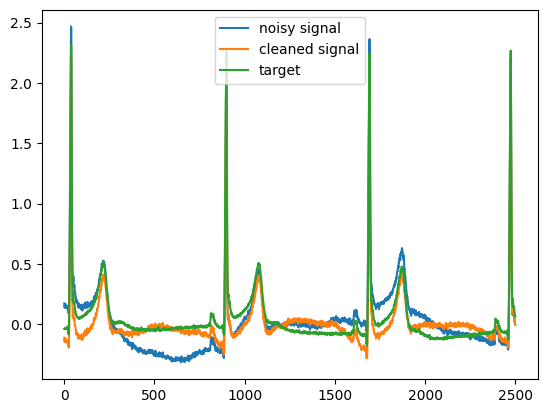

In [150]:
plt.plot(gen_sigs[0:3, :, 9].T)
plt.legend(labels=['noisy signal', 'cleaned signal', 'target'])